# Проект: Статистический анализ данных


## Описание данных

Вы аналитик популярного сервиса аренды самокатов **GoFast**. Вам передали данные о некоторых пользователях из нескольких городов, а также об их поездках. Проанализируйте данные и проверьте некоторые гипотезы, которые могут помочь бизнесу вырасти.

### Условия использования сервиса GoFast

Для совершения поездок по городу пользователи сервиса GoFast используют мобильное приложение. Сервисом можно пользоваться:

- **Без подписки**:
  - Абонентская плата отсутствует;
  - Стоимость одной минуты поездки — **8 рублей**;
  - Стоимость старта (начала поездки) — **50 рублей**.

- **С подпиской Ultra**:
  - Абонентская плата — **199 рублей в месяц**;
  - Стоимость одной минуты поездки — **6 рублей**;
  - Стоимость старта — **бесплатно**.

## Описание данных

В основных данных есть информация о пользователях, их поездках и подписках.

### Пользователи — [users_go.csv](path/to/users_go.csv)
- **user_id**: уникальный идентификатор пользователя
- **name**: имя пользователя
- **age**: возраст
- **city**: город
- **subscription_type**: тип подписки (free, ultra)

### Поездки — [rides_go.csv](path/to/rides_go.csv)
- **user_id**: уникальный идентификатор пользователя
- **distance**: расстояние, которое пользователь проехал в текущей сессии (в метрах)
- **duration**: продолжительность сессии (в минутах) — время с момента нажатия кнопки «Начать поездку» до нажатия кнопки «Завершить поездку»
- **date**: дата совершения поездки

### Подписки — [subscriptions_go.csv](path/to/subscriptions_go.csv)
- **subscription_type**: тип подписки
- **minute_price**: стоимость одной минуты поездки по данной подписке
- **start_ride_price**: стоимость начала поездки
- **subscription_fee**: стоимость ежемесячного платежа

# Основные этапы исследования:
- **Шаг 1.** Загрузка данных
- **Шаг 2.** Предобработка данных
- **Шаг 3.** Исследовательский анализ данных
- **Шаг 4.** Объединение данных
- **Шаг 5.** Подсчёт выручки
- **Шаг 6.** Проверка гипотез
- **Шаг 7.** Распределения

## Импортируем необходимые библиотеки

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats as st
from scipy.stats import binom
from scipy import stats
import seaborn as sns
sns.set(style="whitegrid")

# Зададим необходимые функции

### Функция для отображения количества пользователей на круговой диаграмме

In [2]:
def func(pct, allvalues):
    total = sum(allvalues)
    absolute = int(pct / 100. * total)
    return f"{pct:.1f}%\n({absolute:d})" #Создаем круговую диаграмму

### Функция для расчета помесячной выручки

In [3]:
# Создаем функцию для расчета помесячной выручки
def calculate_monthly_revenue(group):
    total_duration = group['duration'].sum()  # Общее время всех поездок
    ride_count = group['duration'].count()  # Количество поездок
    if group['subscription_type'].iloc[0] == 'ultra':
        monthly_revenue = (ride_count * group['start_ride_price'].iloc[0] +
                           total_duration * group['minute_price'].iloc[0] +
                           group['subscription_fee'].iloc[0])
    else:
        monthly_revenue = (ride_count * group['start_ride_price'].iloc[0] +
                           total_duration * group['minute_price'].iloc[0])
    
    return pd.Series(monthly_revenue, index=['monthly_revenue'])

# Шаг 1. Загрузка и изучение данных

In [5]:
rides_url = 'https://code.s3.yandex.net/datasets/rides_go.csv'
subscriptions_url = 'https://code.s3.yandex.net/datasets/subscriptions_go.csv'
users_url = 'https://code.s3.yandex.net/datasets/users_go.csv'
# Инициализация переменных для DataFrame
rides_df = None
subscriptions_df = None
users_df = None

# Чтение файла rides
try:
    rides_df = pd.read_csv(rides_url)
    print("rides_go.csv успешно загружен.")
except Exception as e:
    print(f"Ошибка при загрузке rides_go.csv: {e}")

# Чтение файла subscriptions
try:
    subscriptions_df = pd.read_csv(subscriptions_url)
    print("subscriptions_go.csv успешно загружен.")
except Exception as e:
    print(f"Ошибка при загрузке subscriptions_go.csv: {e}")

# Чтение файла users
try:
    users_df = pd.read_csv(users_url)
    print("users_go.csv успешно загружен.")
except Exception as e:
    print(f"Ошибка при загрузке users_go.csv: {e}")

rides_go.csv успешно загружен.
subscriptions_go.csv успешно загружен.
users_go.csv успешно загружен.


In [6]:
rides_df.info()
subscriptions_df.info()
users_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   18068 non-null  int64  
 1   distance  18068 non-null  float64
 2   duration  18068 non-null  float64
 3   date      18068 non-null  object 
dtypes: float64(2), int64(1), object(1)
memory usage: 564.8+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   subscription_type  2 non-null      object
 1   minute_price       2 non-null      int64 
 2   start_ride_price   2 non-null      int64 
 3   subscription_fee   2 non-null      int64 
dtypes: int64(3), object(1)
memory usage: 192.0+ bytes
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1565 entries, 0 to 1564
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
--- 

In [7]:
rides_df.head()

,user_id,distance,duration,date
0,1,4409.919140,25.599769,2021-01-01
1,1,2617.592153,15.816871,2021-01-18
2,1,754.159807,6.232113,2021-04-20
3,1,2694.783254,18.511000,2021-08-11
4,1,4028.687306,26.265803,2021-08-28


In [8]:
users_df.head()

,user_id,name,age,city,subscription_type
0,1,Кира,22,Тюмень,ultra
1,2,Станислав,31,Омск,ultra
2,3,Алексей,20,Москва,ultra
3,4,Константин,26,Ростов-на-Дону,ultra
4,5,Адель,28,Омск,ultra


In [9]:
subscriptions_df.head()

,subscription_type,minute_price,start_ride_price,subscription_fee
0,free,8,50,0
1,ultra,6,0,199


In [10]:
print('Количество явных дубликатов в `users_df` = ', users_df.duplicated().sum())
print('Количество явных дубликатов в `rides_df` = ', rides_df.duplicated().sum())

Количество явных дубликатов в `users_df` =  31
Количество явных дубликатов в `rides_df` =  0


### Вывод по шагу 1
- В данных о поездках необходимо устранить 31 явный дубликат.
- Даты в данных о поездках требуют преобразования в подходящий формат для последующего анализа.
Данные рекомендации были применены, также мы открыли и изучили исходные файлы.

# Шаг 2. Предобработка данных

## Удалим явные дубликаты

In [11]:
users_df = users_df.drop_duplicates()

### Выполним следующие действия

1. **Ограничение значений distance**: 
   - Значения в столбце `distance` округляются до двух знаков после запятой.
   
2. **Округление значений duration**:
   - Значения в столбце `duration` округляются вверх до ближайшего целого числа, преобразовывая в целые числа.
   
3. **Преобразование формата даты**:
   - Столбец `date` преобразуется в формат даты.
   
4. **Извлечение месяца из даты**:
   - Новый столбец `month` создается на основе столбца `date`.

In [12]:
rides_df['distance'] = rides_df['distance'].round(2)
rides_df['duration'] = np.ceil(rides_df['duration']).astype('int')
rides_df['date'] = pd.to_datetime(rides_df['date'], format='%Y-%m-%d')
rides_df['month'] = rides_df['date'].dt.month
rides_df['year'] = rides_df['date'].dt.year

In [13]:
# Находим минимальную и максимальную дату
min_date = rides_df['date'].min()
max_date = rides_df['date'].max()

print(f"Период исследования: {min_date.date()} - {max_date.date()}")

Период исследования: 2021-01-01 - 2021-12-30


В датасете представлены данные за 2021 год

<font color='DarkBlue'><b>Комментарий ревьюера</b></font><br>
<font color='DarkMagenta'>👉 Следовало проверить за какой период данные в датасете. Если данные за несколько лет, то номера месяцев будут в разных годах одинаковыми.</font>

In [14]:
# Проверяем на отрицательные значения
negative_durations = rides_df[rides_df['duration'] < 0]
print(f"Отрицательные значения продолжительности: {len(negative_durations)}")
rides_df['duration'].describe()

Отрицательные значения продолжительности: 0


count    18068.000000
mean        18.303520
std          6.094928
min          1.000000
25%         14.000000
50%         18.000000
75%         22.000000
max         41.000000
Name: duration, dtype: float64

В столбце с продолжительностью поездки отсутствуют отрицательные значения. Среднее значение поездки составляет 18 минут 20 секунд. Максимальная продолжительность поездки составила 41 минуту. Я бы не назвал такой показатель аномальным выбросом. Данные в этом столбце в порядке.

### Вывод о предобработке данных (шаг 2)
Во время проведения предобработки данных:
Для данных users_df:


    

Удалили дубликаты.

Для данных rides_df:


    

Округлили distance в метрах до 2 знаков после запятой.

    

Округлили duration до целых чисел вверх и перевели в тип int.

    

Привели столбец date к типу datetime64.

    

Создали столбец month с номером месяца из date.


Для данных subscriptions_df:



    

Изменений не проводили.

### Шаг 3. Исследовательский анализ данных

### Построим круговую диаграмму с топ-10 городами по количеству пользователей

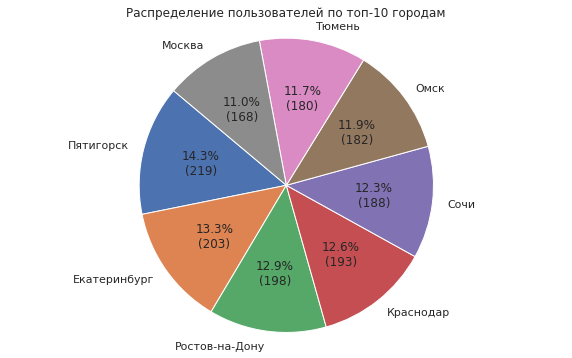

In [15]:
city_counts = users_df['city'].value_counts().reset_index()
city_counts.columns = ['city', 'user_count'] #Получаем топ-10 городов
top_10_cities = city_counts.head(10) 
#Создаем круговую диаграмму
plt.figure(figsize=(10, 6))
#Используем user_count в качестве значений для размера секторов
plt.pie(top_10_cities['user_count'], labels=top_10_cities['city'], autopct=lambda pct: func(pct, top_10_cities['user_count']), startangle=140)
plt.title("Распределение пользователей по топ-10 городам") #Задаем равные соотношения осей для правильного круга
plt.axis('equal')


 #Копировать код
plt.show()

Анализ распространения пользователей самокатов по городам
На графике мы заметили заметное преобладание южных городов среди пользователей самокатов, так как в северных регионах зима может создавать неудобства для использования самокатов, что напрямую влияет на их популярность. В южных регионах такого нет. Также преобладают крупные города, так как наличие в них высокой плотности населения делает их центрами для новых видов транспорта, таких как самокаты.

Наибольшее количество пользователей самокатов зарегистрировано в следующих городах:


 Пятигорск             225                      


 Екатеринбург          205                      


 Ростов-на-Дону       202                      

Неожиданные показатели

Интересно отметить следующие моменты:

Москва занимает лишь десятое место в этом списке - 172 пользователя, что выглядит неожиданным, учитывая ее статус мегаполиса.

Санкт-Петербург и Казань также не вошли в десятку, что удивительно, так как эти города являются крупными и не относятся к северным регионам.

Учитывая данные показатели, отделу маркетинга следует рассмотреть следующие аспекты:

Важно выяснить, какие факторы влияют на количество пользователей в разных городах.

Разработка стратегии повышения привлекательности самокатов в мегаполисах.

### Построим диаграмму с соотношением пользователей с подпиской и без

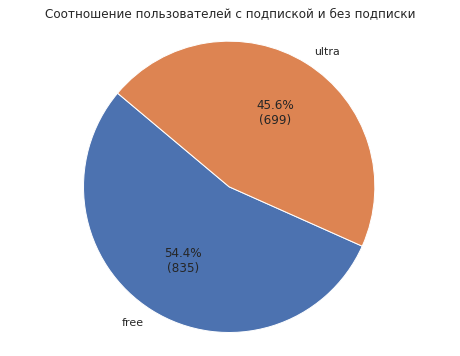

In [16]:
subscription_counts = users_df['subscription_type'].value_counts().reset_index()
subscription_counts.columns = ['subscription_type', 'user_count']


# Создаем круговую диаграмму
plt.figure(figsize=(8, 6))
plt.pie(subscription_counts['user_count'], 
        labels=subscription_counts['subscription_type'], 
        autopct=lambda pct: func(pct, subscription_counts['user_count']), 
        startangle=140)
plt.title("Соотношение пользователей с подпиской и без подписки")
plt.axis('equal')  # Равные соотношения осей для правильного круга
plt.show()

Пользователей без подписки больше, чем с подпиской.

### График распределения возраста клиентов

In [17]:
users_df["age"].describe()

count    1534.000000
mean       24.903520
std         4.572367
min        12.000000
25%        22.000000
50%        25.000000
75%        28.000000
max        43.000000
Name: age, dtype: float64

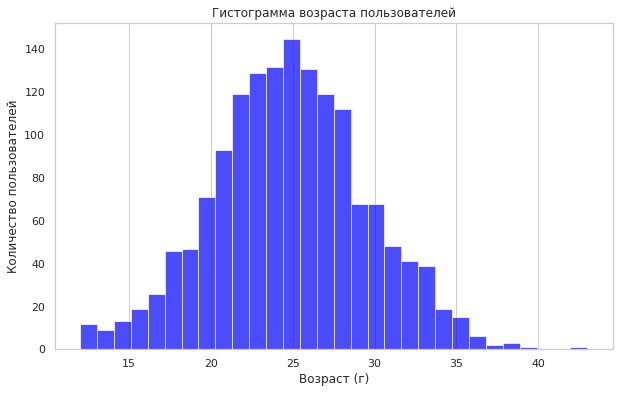

In [18]:
# Гистограмма возраста пользователей
plt.figure(figsize=(10, 6))
plt.hist(users_df["age"], bins=30, color="blue", alpha=0.7)
plt.title("Гистограмма возраста пользователей")
plt.xlabel("Возраст (г)")
plt.ylabel("Количество пользователей")
plt.grid(axis="y")
plt.show()

### Анализ возрастного распределения пользователей самокатов
На представленном графике наблюдается нормальное распределение пользователей самокатов по возрастным категориям. Наибольшее количество пользователей отмечено в возрастной группе 25 лет. Это вполне логично, поскольку:


    

Дети: Использование самокатов детьми связано с определенными рисками, что делает такое катание небезопасным. Также сервису необходимо ужесточить контроль по отношению к несовершеннолетним пользователям. Согласно законодательству пользоваться самокатами разрешено по достижении 18 лет либо с 14 при согласии родителей.

    

Взрослые: Люди старшего возраста часто менее физически активны, что ограничивает их возможности использования самокатов.

### График распределения расстояния поездок

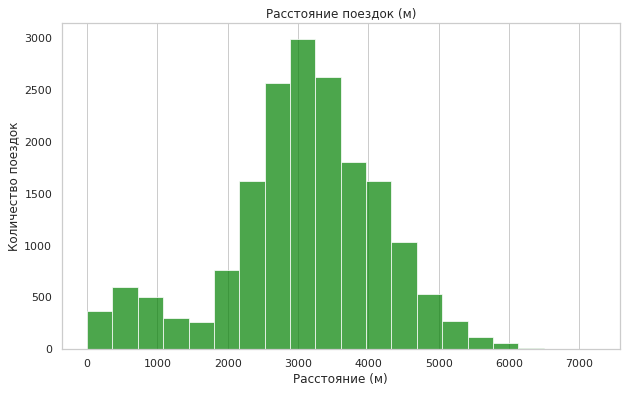

In [19]:
# Гистограмма расстояния поездок
plt.figure(figsize=(10, 6))
plt.hist(rides_df["distance"], bins=20, color="green", alpha=0.7)
plt.title("Расстояние поездок (м)")
plt.xlabel("Расстояние (м)")
plt.ylabel("Количество поездок")
plt.grid(axis="y")
plt.show()

В основном мы видим, что наибольшее количество пользователей совершают поездку на расстояние 2,5-4 км. Также мы наблюдаем локальный максимум среди коротких поездок, который составляет 500 м.

### График распределения продолжительности поездок

In [20]:
rides_df["duration"].describe()

count    18068.000000
mean        18.303520
std          6.094928
min          1.000000
25%         14.000000
50%         18.000000
75%         22.000000
max         41.000000
Name: duration, dtype: float64

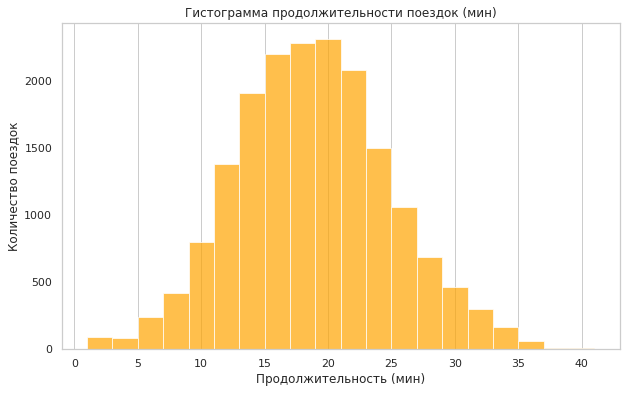

In [21]:
# Гистограмма продолжительности поездок
plt.figure(figsize=(10, 6))
plt.hist(rides_df["duration"], bins=20, color="orange", alpha=0.7)
plt.title("Гистограмма продолжительности поездок (мин)")
plt.xlabel("Продолжительность (мин)")
plt.ylabel("Количество поездок")
plt.grid(axis="y")
plt.show()

In [22]:
count_short_rides = rides_df[rides_df["duration"] <= 1].shape[0]
print(f"Количество поездок с продолжительностью 1 минута: {count_short_rides}")


Количество поездок с продолжительностью 1 минута: 95


В основном мы видим, что наибольшее количество пользователей находятся в поездке от 12 до 25 минут. 

Поездок меньше 1 минуты нет. Думаю в сервисе минимальная доступная для покупки длительность поездки составляет 1 минута. Таких поездок - 95.

### График распределения количества поездок по месяцам

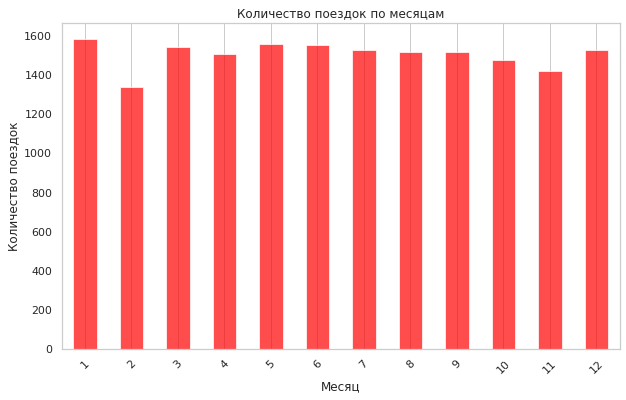

In [23]:

    # Гистограмма количества поездок по месяцам
    plt.figure(figsize=(10, 6))
    rides_df['month'].value_counts().sort_index().plot(kind='bar', color='red', alpha=0.7)
    plt.title("Количество поездок по месяцам")
    plt.xlabel("Месяц")
    plt.ylabel("Количество поездок")
    plt.xticks(rotation=45)
    plt.grid(axis="y")
    plt.show()


В целом мы видим равномерное распределение количества поездок по месяцам. Это достаточно странно, так как нет сезонной просадки. Хотя вполне возможно, что общая статистика выравнивается за счет южных регионов.

### Вывод по анализу распространения пользователей самокатов и возрастного распределения

Из анализа можно сделать несколько ключевых выводов:

Географическая предрасположенность: Преобладание пользователей самокатов в южных городах объясняется благоприятными климатическими условиями, которые не мешают использованию данного вида транспорта. В то время как в северных регионах холодная погода и снег создают препятствия для регулярного использования самокатов.

Крупные городские центры: Высокая плотность населения в крупных городах способствует росту популярности самокатов. Это связано с наличием развитой инфраструктуры и потребностью жителей в альтернативных и быстрых способах передвижения.

Неожиданные результаты для мегаполисов: 

Москва на десятом месте с 172 пользователями выглядит неожиданным. Вероятно, следует исследовать конкретные причины низкой популярности, такие как высокие транспортные заторы, нехватка инфраструктуры для самокатов или низкий интерес к альтернативным видам транспорта.

Санкт-Петербург и Казань также удивляют отсутствием пользователей самокатов. Важно провести опросы и исследования, чтобы определить, какие факторы могут быть причиной.

Возрастное распределение: Нормальное распределение пользователей по возрастным категориям показывает, что самая активная группа - это 25-летние. Это связано с тем, что молодые люди более подвержены экспериментам с новыми технологиями и видами транспорта. В то же время молодые дети и пожилые люди имеют ограничения, что снижает их участие.

Расстояние и время поездки: Наибольшее количество поездок осуществляется на расстояния 2,5-4 км и занимает от 12 до 25 минут. Эти данные могут помочь в планировании маршрутов и улучшении инфраструктуры.

Отсутствие сезонных колебаний: Равномерное распределение поездок в течение года может быть объяснено доминированием южных регионов, где погодные условия способствуют постоянному использованию самокатов.
Рекомендации для отдела маркетинга:


Проводить более глубокие исследования для понимания причин низкой популярности самокатов в мегаполисах.

Разработать стратегии, направленные на повышение интереса к самокатам в этих городах, учитывая их особенности.

Учитывать возрастные группы в маркетинговых стратегиях для привлечения пользователей.
Эти выводы помогут в лучшее понимание текущих тенденций и разработке эффективных стратегий для увеличения использования самокатов в городах.

<font color='DarkBlue'><b>Комментарий ревьюера</b></font><br>
<font color='DarkGreen'>👌 Хорошо, что раздел анализа заканчиваем обобщающим выводом.</font>

## Шаг 4. Объединение данных

In [24]:
merged_rides_users = pd.merge(rides_df, users_df, on='user_id', how='left')
final_merged_df = pd.merge(merged_rides_users, subscriptions_df, on='subscription_type', how='left')
display(final_merged_df.head())

,user_id,distance,duration,date,month,year,name,age,city,subscription_type,minute_price,start_ride_price,subscription_fee
0,1,4409.92,26,2021-01-01,1,2021,Кира,22,Тюмень,ultra,6,0,199
1,1,2617.59,16,2021-01-18,1,2021,Кира,22,Тюмень,ultra,6,0,199
2,1,754.16,7,2021-04-20,4,2021,Кира,22,Тюмень,ultra,6,0,199
3,1,2694.78,19,2021-08-11,8,2021,Кира,22,Тюмень,ultra,6,0,199
4,1,4028.69,27,2021-08-28,8,2021,Кира,22,Тюмень,ultra,6,0,199


In [25]:
# Проверка размерности датасета
shape = final_merged_df.shape
print(f"Размерность датасета: {shape}")

Размерность датасета: (18068, 13)


In [26]:
final_merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18068 entries, 0 to 18067
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   user_id            18068 non-null  int64         
 1   distance           18068 non-null  float64       
 2   duration           18068 non-null  int64         
 3   date               18068 non-null  datetime64[ns]
 4   month              18068 non-null  int64         
 5   year               18068 non-null  int64         
 6   name               18068 non-null  object        
 7   age                18068 non-null  int64         
 8   city               18068 non-null  object        
 9   subscription_type  18068 non-null  object        
 10  minute_price       18068 non-null  int64         
 11  start_ride_price   18068 non-null  int64         
 12  subscription_fee   18068 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(8), object(3)
memory 

Размерность датасета: (18068, 12). Пропуски отсутствуют.

## Создание новых датафреймов для пользователей с подпиской и без

In [27]:
users_with_subscription = final_merged_df[final_merged_df['subscription_type'] == 'ultra']
users_without_subscription = final_merged_df[final_merged_df['subscription_type'] == 'free']
display(users_with_subscription.head())
display(users_without_subscription.head())

,user_id,distance,duration,date,month,year,name,age,city,subscription_type,minute_price,start_ride_price,subscription_fee
0,1,4409.92,26,2021-01-01,1,2021,Кира,22,Тюмень,ultra,6,0,199
1,1,2617.59,16,2021-01-18,1,2021,Кира,22,Тюмень,ultra,6,0,199
2,1,754.16,7,2021-04-20,4,2021,Кира,22,Тюмень,ultra,6,0,199
3,1,2694.78,19,2021-08-11,8,2021,Кира,22,Тюмень,ultra,6,0,199
4,1,4028.69,27,2021-08-28,8,2021,Кира,22,Тюмень,ultra,6,0,199


,user_id,distance,duration,date,month,year,name,age,city,subscription_type,minute_price,start_ride_price,subscription_fee
6500,700,2515.69,15,2021-01-02,1,2021,Айдар,22,Омск,free,8,50,0
6501,700,846.93,17,2021-02-01,2,2021,Айдар,22,Омск,free,8,50,0
6502,700,4004.43,21,2021-02-04,2,2021,Айдар,22,Омск,free,8,50,0
6503,700,1205.91,10,2021-02-10,2,2021,Айдар,22,Омск,free,8,50,0
6504,700,3047.38,18,2021-02-14,2,2021,Айдар,22,Омск,free,8,50,0


<font color='DarkBlue'><b>Комментарий ревьюера</b></font><br>
<font color='DarkGreen'>👌 Хорошо, датасеты созданы без ошибок.</font>

## Гистограммы распределения расстояний поездок для обеих когорт

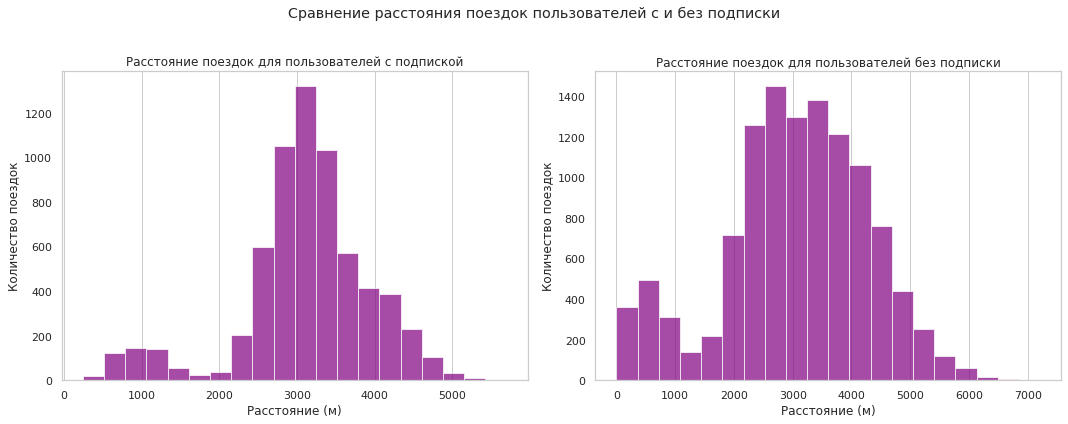

In [28]:
fig, ax = plt.subplots(1, 2, figsize=(15, 6))

# Гистограмма расстояния поездок для пользователей с подпиской
ax[0].hist(users_with_subscription["distance"], bins=20, color="purple", alpha=0.7)
ax[0].set_title("Расстояние поездок для пользователей с подпиской")
ax[0].set_xlabel("Расстояние (м)")
ax[0].set_ylabel("Количество поездок")
ax[0].grid(axis="y")

# Гистограмма расстояния поездок для пользователей без подписки
ax[1].hist(users_without_subscription["distance"], bins=20, color="purple", alpha=0.7)
ax[1].set_title("Расстояние поездок для пользователей без подписки")
ax[1].set_xlabel("Расстояние (м)")
ax[1].set_ylabel("Количество поездок")
ax[1].grid(axis="y")

# Общее заглавие для графиков
plt.suptitle("Сравнение расстояния поездок пользователей с и без подписки")

# Показываем графики
plt.tight_layout(rect=[0, 0, 1, 0.96])  # Для корректной компоновки заголовка
plt.show()

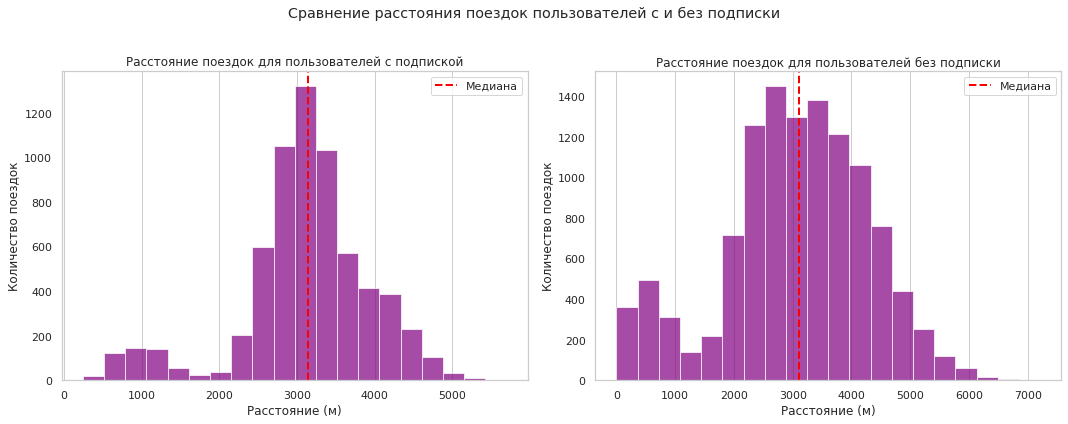

In [29]:
# Вычисление медиан
median_with_subscription = np.median(users_with_subscription["distance"])
median_without_subscription = np.median(users_without_subscription["distance"])

fig, ax = plt.subplots(1, 2, figsize=(15, 6))

# Гистограмма расстояния поездок для пользователей с подпиской
ax[0].hist(users_with_subscription["distance"], bins=20, color="purple", alpha=0.7)
ax[0].set_title("Расстояние поездок для пользователей с подпиской")
ax[0].set_xlabel("Расстояние (м)")
ax[0].set_ylabel("Количество поездок")
ax[0].grid(axis="y")
# Добавление медианной линии
ax[0].axvline(median_with_subscription, color='red', linestyle='dashed', linewidth=2, label='Медиана')
ax[0].legend()

# Гистограмма расстояния поездок для пользователей без подписки
ax[1].hist(users_without_subscription["distance"], bins=20, color="purple", alpha=0.7)
ax[1].set_title("Расстояние поездок для пользователей без подписки")
ax[1].set_xlabel("Расстояние (м)")
ax[1].set_ylabel("Количество поездок")
ax[1].grid(axis="y")
# Добавление медианной линии
ax[1].axvline(median_without_subscription, color='red', linestyle='dashed', linewidth=2, label='Медиана')
ax[1].legend()

# Общее заглавие для графиков
plt.suptitle("Сравнение расстояния поездок пользователей с и без подписки")

# Показываем графики
plt.tight_layout(rect=[0, 0, 1, 0.96])  # Для корректной компоновки заголовка
plt.show()

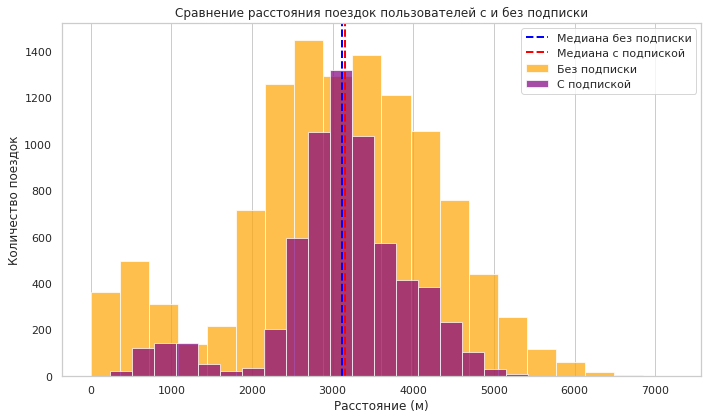

In [30]:
# Вычисление медиан
median_with_subscription = np.median(users_with_subscription["distance"])
median_without_subscription = np.median(users_without_subscription["distance"])

# Создание графика
fig, ax = plt.subplots(figsize=(10, 6))

# Гистограмма расстояния поездок для пользователей без подписки (отображается первым)
ax.hist(users_without_subscription["distance"], bins=20, color="orange", alpha=0.7, label="Без подписки")

# Гистограмма расстояния поездок для пользователей с подпиской (отображается поверх)
ax.hist(users_with_subscription["distance"], bins=20, color="purple", alpha=0.7, label="С подпиской")

# Заголовок и подписи
ax.set_title("Сравнение расстояния поездок пользователей с и без подписки")
ax.set_xlabel("Расстояние (м)")
ax.set_ylabel("Количество поездок")
ax.grid(axis="y")

# Добавление медианных линий
ax.axvline(median_without_subscription, color="blue", linestyle="dashed", linewidth=2, label="Медиана без подписки")
ax.axvline(median_with_subscription, color="red", linestyle="dashed", linewidth=2, label="Медиана с подпиской")

# Легенда
ax.legend()

# Показываем графики
plt.tight_layout()
plt.show()

Сделал. Предыдущие графики не стал удалять.

## Выводы из наблюдения за графиками

Согласно представленным графикам, можно сделать следующие выводы:


Пользователи с подпиской:

В среднем они проезжают от 2,8 до 3,4 км.

Пользователи, которые ездят на большие или меньшие расстояния, значительно реже, в 2-3 раза меньше по сравнению с основной массой.

Пользователи без подписки:

У них наблюдается более широкий диапазон поездок, в основном от 2,2 до 4,2 км, что превышает показатели пользователей с подпиской.

Пользователи без подписки в 2-2,5 раза чаще совершают поездки до 1 км по сравнению с подписчиками.

## Гистограммы распределения длительности поездок для обеих когорт

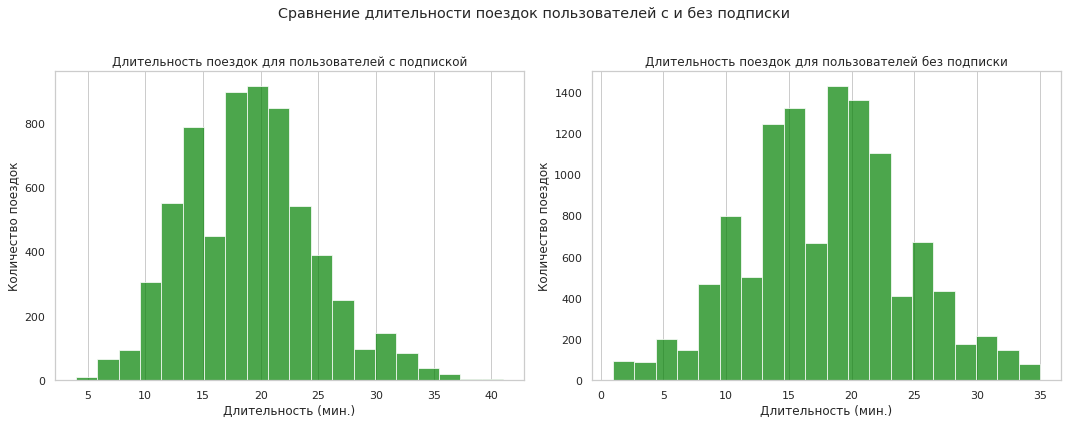

In [31]:
# Создание двух подграфиков
fig, ax = plt.subplots(1, 2, figsize=(15, 6))

# Гистограмма длительности поездок для пользователей с подпиской
ax[0].hist(users_with_subscription["duration"], bins=20, color="green", alpha=0.7)
ax[0].set_title("Длительность поездок для пользователей с подпиской")
ax[0].set_xlabel("Длительность (мин.)")
ax[0].set_ylabel("Количество поездок")
ax[0].grid(axis="y")

# Гистограмма длительности поездок для пользователей без подписки
ax[1].hist(users_without_subscription["duration"], bins=20, color="green", alpha=0.7)
ax[1].set_title("Длительность поездок для пользователей без подписки")
ax[1].set_xlabel("Длительность (мин.)")
ax[1].set_ylabel("Количество поездок")
ax[1].grid(axis="y")

# Общее заглавие для графиков
plt.suptitle("Сравнение длительности поездок пользователей с и без подписки")

# Показываем графики
plt.tight_layout(rect=[0, 0, 1, 0.96])  # Для корректной компоновки заголовка
plt.show()

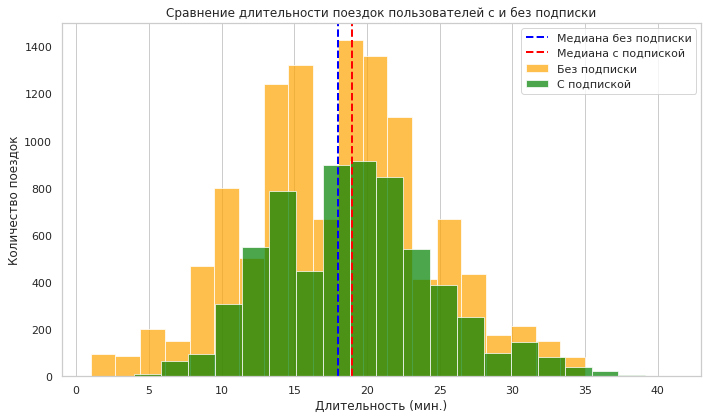

In [32]:
# Вычисление медиан
median_duration_with_subscription = np.median(users_with_subscription["duration"])
median_duration_without_subscription = np.median(users_without_subscription["duration"])

# Создание графика
fig, ax = plt.subplots(figsize=(10, 6))

# Гистограмма длительности поездок для пользователей без подписки (отображается первым)
ax.hist(users_without_subscription["duration"], bins=20, color="orange", alpha=0.7, label="Без подписки")

# Гистограмма длительности поездок для пользователей с подпиской (отображается поверх)
ax.hist(users_with_subscription["duration"], bins=20, color="green", alpha=0.7, label="С подпиской")

# Заголовок и подписи
ax.set_title("Сравнение длительности поездок пользователей с и без подписки")
ax.set_xlabel("Длительность (мин.)")
ax.set_ylabel("Количество поездок")
ax.grid(axis="y")
ax.axvline(median_duration_without_subscription, color="blue", linestyle="dashed", linewidth=2, label="Медиана без подписки")
ax.axvline(median_duration_with_subscription, color="red", linestyle="dashed", linewidth=2, label="Медиана с подпиской")

# Легенда
ax.legend()

# Показываем графики
plt.tight_layout()
plt.show()

## Сравнение длительности поездок пользователей с подпиской и без

Сравнив два графика, отображающие длительность поездок для пользователей с подпиской и без, можно сделать следующие выводы:


В целом графики похожи.

Обе когорты пользователей распределены в диапазоне длительности поездок от 0 до 35 минут.

Пики количества пользователей приходятся на 15 и 20 минут.

### Общий вывод (шаг 4):

Мы проанализировали поведение пользователей с подпиской и без подписки на основе двух созданных датафреймов, которые были сформированы из объединенных трех исходных датафреймов. Пользователи с подпиской, в среднем, совершают поездки длиной от 2,8 до 3,4 км, в то время как пользователи без подписки имеют более широкий диапазон — от 2,2 до 4,2 км. 

При этом пользователи без подписки значительно чаще (в 2-2,5 раза) совершают короткие поездки до 1 км. Оба графика, отображающие продолжительность поездок, показывают схожесть в распределении, пик пользователей наблюдается на отметках 15 и 20 минут.

Таким образом, пользователи с подпиской имеют более консервативные поездки по длине и времени, в отличие от более разнообразных и кратковременных поездок пользователей без подписки.

### Шаг 5. Подсчёт выручки

#### Найдем суммарное расстояние, общее количество поездок, общую продолжительность поездок для каждого пользователя помесячно

In [33]:
# Группировка данных с добавлением столбца subscription_type
aggregated_df = final_merged_df.groupby(['user_id', 'month', 'subscription_type']).agg(
    total_distance=('distance', 'sum'),
    total_rides=('distance', 'count'),
    total_duration=('duration', 'sum')
).reset_index()

# Вывод результата для 1 пользователя. Для примера.
display(aggregated_df[aggregated_df['user_id'] == 1])

,user_id,month,subscription_type,total_distance,total_rides,total_duration
0,1,1,ultra,7027.51,2,42
1,1,4,ultra,754.16,1,7
2,1,8,ultra,6723.47,2,46
3,1,10,ultra,5809.91,2,32
4,1,11,ultra,7003.50,3,56
5,1,12,ultra,6751.63,2,28


In [34]:
aggregated_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11331 entries, 0 to 11330
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   user_id            11331 non-null  int64  
 1   month              11331 non-null  int64  
 2   subscription_type  11331 non-null  object 
 3   total_distance     11331 non-null  float64
 4   total_rides        11331 non-null  int64  
 5   total_duration     11331 non-null  int64  
dtypes: float64(1), int64(4), object(1)
memory usage: 531.3+ KB


In [35]:
# Проверка на пропуски и вывод информации
missing_values = aggregated_df.isnull().sum()
missing_summary = missing_values[missing_values > 0]

if not missing_summary.empty:
    print("Пропущенные значения по столбцам:")
    print(missing_summary)
else:
    print("В датафрейме нет пропусков")

В датафрейме нет пропусков


<font color='DarkBlue'><b>Комментарий ревьюера</b></font><br>
<font color='Red'>🛠 Перед расчетом выручки необходимо сделать проверку на пропуски в созданной сводной таблице.</font>

#### Найдем общую выручку помесячно для каждого пользователя.

In [36]:
# Группируем и вычисляем помесячную выручку для каждого user_id и month
monthly_revenue_df = final_merged_df.groupby(['user_id', 'month'], as_index=False).apply(calculate_monthly_revenue)

# Объединяем с агрегированным датафреймом, используя уникальные суффиксы
aggregated_df = aggregated_df.merge(monthly_revenue_df.reset_index(), on=['user_id', 'month'], how='left', suffixes=('', '_rev'))

# Оставляем только необходимые столбцы
final_result = aggregated_df[['user_id', 'month', 'total_distance', 'total_rides', 'total_duration', 'monthly_revenue', 'subscription_type']]

# Вывод результата
display(final_result.head())

,user_id,month,total_distance,total_rides,total_duration,monthly_revenue,subscription_type
0,1,1,7027.51,2,42,451,ultra
1,1,4,754.16,1,7,241,ultra
2,1,8,6723.47,2,46,475,ultra
3,1,10,5809.91,2,32,391,ultra
4,1,11,7003.50,3,56,535,ultra


#### Вычислим суммарную выручку

In [37]:
# Вычисляем суммарную выручку
total_revenue = final_result['monthly_revenue'].sum()

# Выводим суммарную выручку
print(f"Выручка сервиса аренды самокатов GoFast за год составила: {total_revenue} рублей")

Выручка сервиса аренды самокатов GoFast за год составила: 3878641 рублей


In [38]:
# Комментарий ревьюера
# Контроль суммы выручки
tmp = final_result.copy()
print("Правильное значение суммы выручки 3878641, сумма выручки расчитанная в таблице:", tmp.monthly_revenue.sum())

Правильное значение суммы выручки 3878641, сумма выручки расчитанная в таблице: 3878641


#### Вывод по 5 шагу:
Рассчитали суммарное расстояние, общее количество поездок, общую продолжительность поездок и месячную выручку для каждого пользователя помесячно. Занесли эти данные в новые столбцы.
Рассчитали суммарную выручку, она составила 3878641.0 рублей


### Шаг 6. Проверка гипотез

#### Для выяснения вопроса о том, тратят ли пользователи с подпиской больше времени на поездку, чем пользователи без подписки, выдвинем следующие гипотезы:

Гипотезы

Н0 (нулевая гипотеза): Средняя продолжительность поездок с подпиской ultra равна средней продолжительности поездок для пользователей с бесплатной подпиской (free).

Н1 (альтернативная гипотеза): Средняя продолжительность поездок с подпиской ultra больше, чем продолжительность поездок для пользователей с бесплатной подпиской (free).
Эти гипотезы помогут нам проанализировать данные и выяснить, действительно ли подписка влияет на время, проводимое пользователями в поездках.

Зададим уровень значимости - 5%

<font color='DarkBlue'><b>Комментарий ревьюера</b></font><br>
<font color='DarkGreen'>👌 Хорошо, правильно сформулированы гипотезы.</font>

In [39]:
# Извлечение продолжительности поездок для каждого типа подписки
durations_ultra = users_with_subscription['duration']
durations_free = users_without_subscription['duration']

# Выполнение t-теста
t_statistic, p_value = stats.ttest_ind(durations_ultra, durations_free, alternative='greater')

# Вывод результатов
print(f"T-Statistic: {t_statistic}")
print(f"P-Value: {p_value}")

# Проверка гипотез
alpha = 0.05
if p_value < alpha:
    print("Отвергаем H0")
else:
    print("Нет оснований отвергать H0")

T-Statistic: 12.186464491247767
P-Value: 2.4959453720736625e-34
Отвергаем H0


In [40]:

# Извлечение продолжительности поездок для каждого типа подписки
durations_ultra = users_with_subscription['duration']
durations_free = users_without_subscription['duration']

# Вычисление средних значений
mean_ultra = durations_ultra.mean()
mean_free = durations_free.mean()

# Выполнение t-теста
t_statistic, p_value = stats.ttest_ind(durations_ultra, durations_free, alternative='greater')

# Вывод результатов
print(f"T-Statistic: {t_statistic}")
print(f"P-Value: {p_value}")

# Вывод средних значений
print(f"Среднее время поездок для пользователей с подпиской: {mean_ultra:.2f} секунд")
print(f"Среднее время поездок для пользователей без подписки: {mean_free:.2f} секунд")

# Проверка гипотез
alpha = 0.05
if p_value < alpha:
    print("Отвергаем H0")
else:
    print("Нет оснований отвергать H0")

T-Statistic: 12.186464491247767
P-Value: 2.4959453720736625e-34
Среднее время поездок для пользователей с подпиской: 19.04 секунд
Среднее время поездок для пользователей без подписки: 17.89 секунд
Отвергаем H0


## Вывод:

Мы получили результат:

- **T-Statistic:** 12.186464491247767

- **P-Value:** 2.4959453720736625e-34

Средние значения времени поездок составляют:

- Среднее время поездок для пользователей с подпиской: 19.04 секунд.

- Среднее время поездок для пользователей без подписки: 17.89 секунд.

Поскольку значение p (P-Value) значительно меньше уровня значимости (alpha = 0.05), мы отвергли нулевую гипотезу (H0). Это означает, что у нас есть достаточные основания утверждать, что средняя продолжительность поездок с подпиской ultra действительно больше, чем у пользователей с бесплатной подпиской (free).

Метод:
Для проверки гипотез мы применили t-тест независимых выборок, который позволяет сравнивать средние значения двух независимых групп и определяет, существует ли статистически значимая разница между ними. Этот тест указывает на наличие значимой разницы между двумя группами в контексте их средней длительности поездок, что также подтверждается более высокими значениями средних для группы подписчиков.

#### Проверим, можно ли утверждать, что среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров? 

Выдвинем гипотезы: 

Н0: Среднее расстояние поездок с подпиской ultra равно оптимальному расстоянию в 3130 метров.

Н1: Среднее расстояние поездок с подпиской ultra больше оптимального в 3130 метров.

Зададим уровень значимости - 5%

<font color='DarkBlue'><b>Комментарий ревьюера</b></font><br>
<font color='DarkGreen'>👌 Хорошо, правильно сформулированы гипотезы.</font>

In [41]:
# Извлечение расстояний для пользователей с подпиской
distances_ultra = users_with_subscription['distance']

# Оптимальное расстояние
optimal_distance = 3130

# Выполнение одностороннего t-теста
t_statistic, p_value = stats.ttest_1samp(distances_ultra, optimal_distance, alternative='greater')

# Вывод результатов
print(f"T-Statistic: {t_statistic}")
print(f"P-Value: {p_value}")

# Проверка гипотез
alpha = 0.05
if p_value < alpha and t_statistic > 0:
    print("Отвержена H0: Среднее расстояние поездок с подпиской ultra превышает оптимальное расстояние в 3130 метров.")
else:
    print("Нет оснований отвергать H0: Среднее расстояние поездок с подпиской ultra не превышает оптимальное расстояние в 3130 метров.") 

T-Statistic: -1.402118985377693
P-Value: 0.9195362605842414
Нет оснований отвергать H0: Среднее расстояние поездок с подпиской ultra не превышает оптимальное расстояние в 3130 метров.


### Вывод:

После проведения одностороннего t-теста с использованием уровня значимости 5% были получены следующие результаты:

    - **T-Statistic:** -1.402118985377693

    - **P-Value:** 0.9195362605842414

Так как значение p (P-Value) превышает уровень значимости (alpha = 0.05), и статистика t меньше 0, мы не можем отвергнуть нулевую гипотезу (H0). Это означает, что среднее расстояние поездок с подпиской ultra не превышает оптимальное расстояние в 3130 метров, и у нас нет оснований заявлять об этом.

### Метод:

Для проверки гипотез был применен односторонний t-тест, который позволяет проверить, отличается ли среднее значение выборки от заданного значения (в данном случае - оптимального расстояния 3130 метров).

#### Проверим гипотезу о том, будет ли помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки. 

Н0: средняя месячная выручка от пользователей с подпиской равна помесячной выручке от пользователей без подписки.

Н1: средняя месячная выручка от пользователей с подпиской больше  помесячной выручке от пользователей без подписки.

Зададим уровень значимости - 5%

In [42]:
# Извлечение выручки для пользователей с и без подписки
revenue_with_subscription = final_result[final_result['subscription_type'] == 'ultra']['monthly_revenue']
revenue_without_subscription = final_result[final_result['subscription_type'] == 'free']['monthly_revenue']

# Выполнение одностороннего t-теста
t_statistic, p_value = stats.ttest_ind(revenue_with_subscription, revenue_without_subscription, alternative='greater')

# Вывод результатов
print(f"T-Statistic: {t_statistic}")
print(f"P-Value: {p_value}")

# Проверка гипотез
alpha = 0.05
if p_value < alpha and t_statistic > 0:
    print("Отвержена Н0: средняя месячная выручка от пользователей с подпиской выше, чем выручка от пользователей без подписки.")
else:
    print("Нет оснований отвергать Н0: Средняя месячная выручка от пользователей с подпиской не превышает выручку от пользователей без подписки.")

T-Statistic: 11.64246602360774
P-Value: 1.8850394384715216e-31
Отвержена Н0: средняя месячная выручка от пользователей с подпиской выше, чем выручка от пользователей без подписки.


### Вывод:

После проведения одностороннего t-теста с использованием уровня значимости 5% были получены следующие результаты:

    - **T-Statistic:** 11.64246602360774

    - **P-Value:** 1.8850394384715216e-31

Так как значение p (P-Value) значительно меньше уровня значимости (alpha = 0.05), и статистика t больше 0, мы отвергаем нулевую гипотезу (Н0). Это означает, что помесячная выручка от пользователей с подпиской действительно выше, чем выручка от пользователей без подписки.

### Метод:

Для проверки гипотез был использован односторонний t-тест для независимых выборок, который позволяет сравнивать средние значения двух независимых групп и определять, существует ли статистически значимая разница между ними.

#### Разберем ситуацию: техническая команда сервиса обновила сервера, с которыми взаимодействует мобильное приложение. Она надеется, что из-за этого количество обращений в техподдержку значимо снизилось. Некоторый файл содержит для каждого пользователя данные о количестве обращений до обновления и после него. Какой тест вам понадобился бы для проверки этой гипотезы?

В данном случае для проверки гипотезы о том, что обновление серверов привело к значительному снижению количества обращений в техподдержку, вам потребуется использовать парный t-тест . Этот тест подходит для анализа двух связанных выборок, например:

Количество обращений в техподдержку до обновления (первая выборка).

Количество обращений в техподдержку после обновления (вторая выборка).
Почему используем именно парный t-тест?

Связанные выборки: Так как вы сравниваете данные для одних и тех же пользователей (одни и те же объекты) в разные временные моменты (до и после обновления), выборки являются зависимыми.

Так как нас интересует только снижение (а не снижение или увеличение), то гипотеза односторонняя.

## Вывод (шаг 6)
### В ходе анализа данных была проведена проверка нескольких гипотез, касающихся характеристик пользователей и изменений в работе сервиса. 


- Проверка времени поездок: Гипотеза о равенстве времени поездки для когорт пользователей с различными типами подписок была отвергнута. Полученные результаты дают основания утверждать, что средняя продолжительность поездок для пользователей с подпиской 'ultra' превышает аналогичное значение для пользователей без подписок 'free'.

- Анализ расстояния поездок: Среднее расстояние поездок для подписчиков 'ultra' не превышает оптимальное значение в 3130 метров, что позволяет не отвергать нулевую гипотезу о его равенстве. Это может говорить о том, что пользователи, обладающие подпиской, не используют весь потенциал сервиса в плане расстояний.

- Проверка выручки: Наличие статистически значимого различия в помесячной выручке между пользователями с подпиской и без нее позволяет сделать вывод о том, что выручка от пользователей с подпиской выше, чем от пользователей без подписки.

- Анализ обращений в техподдержку: Для проверки гипотезы о влиянии обновления серверов на количество обращений в техподдержку был рекомендован парный t-тест, что объясняется наличием зависимых выборок - количество обращений до и после обновления анализировалось для одних и тех же пользователей.
Таким образом, результаты анализа показывают, что обновления и отличия в подписках пользователей оказывают значительное влияние на поведение пользователей и, соответственно, на бизнес-показатели сервиса. Это подчеркивает важность эффективного управления подписками и постоянного мониторинга пользовательского опыта для достижения желаемых результатов.

# Шаг 7

### Задача 1

Отделу маркетинга GoFast поставили задачу: нужно провести акцию с раздачей промокодов на один бесплатный месяц подписки, в рамках которой как минимум 
100 существующих клиентов должны продлить эту подписку. То есть по завершении периода действия подписки пользователь может либо отказаться от неё, либо продлить, совершив соответствующий платёж. 
Эта акция уже проводилась ранее и по итогу выяснилось, что после бесплатного пробного периода подписку продлевают
10 % пользователей. Выясните, какое минимальное количество промокодов нужно разослать, чтобы вероятность не выполнить план была примерно 
5 %. Подберите параметры распределения, описывающего эту ситуацию, постройте график распределения и сформулируйте ответ на вопрос о количестве промокодов.

Значение N при достижении уровня значимости 0.05: 1161


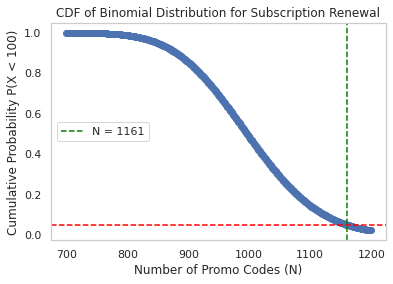

In [43]:
p = 0.1  # вероятность продления
N_values = np.arange(700, 1200, 1)  # диапазон значений N
k = 100
probabilities = [binom.cdf(k-1, N, p) for N in N_values]

# Находим значение N при котором кривая пересекает уровень значимости 0.05
N_intersect_index = np.where(np.array(probabilities) <= 0.05)[0][0]
N_intersect = N_values[N_intersect_index]

# Выводим значение N
print(f'Значение N при достижении уровня значимости 0.05: {N_intersect}')

plt.plot(N_values, probabilities, marker='o')
plt.axhline(0.05, color='red', linestyle='--')
plt.axvline(N_intersect, color='green', linestyle='--', label=f'N = {N_intersect}')
plt.title('CDF of Binomial Distribution for Subscription Renewal')
plt.xlabel('Number of Promo Codes (N)')
plt.ylabel('Cumulative Probability P(X < 100)')
plt.grid()
plt.legend()
plt.show()

### Вывод о проделанной работе (Шаг 7 Задача 1)

В рамках данной задачи мы провели оценку необходимого количества промокодов, которые нужно разослать потенциальным клиентам, чтобы гарантировать, что хотя бы 100 из них продлят подписку после бесплатного пробного месяца. С учетом ранее собранных данных о том, что 10% пользователей продлевают свою подписку после пробного периода, мы стремились определить минимальное количество промокодов, которое обеспечит вероятность продления не менее 5%.

### Использованный метод

Для решения этой задачи мы применили **биномиальное распределение**. Мы сформулировали гипотезы следующим образом:
- **Н0**: Количество пользователей, продливших подписку, не достигает 100 при отправке определенного количества промокодов.

- **Н1**: Количество пользователей, продливших подписку, достигает 100 при отправке определенного количества промокодов.

С помощью кумулятивной функции распределения (CDF) биномиального распределения мы рассматривали вероятность того, что менее 100 пользователей продлят свою подписку. Параметры для модели были заданы как:
- \( p = 0.1 \) (вероятность продления для одного пользователя)

- \( N \) (количество отправленных промокодов)

Мы исследовали диапазон от 700 до 1200 промокодов и рассчитали кумулятивные вероятности для каждого значения \( N \). Далее мы определили минимальное значение \( N \), при котором вероятность того, что менее 100 пользователей продлят подписку, будет менее 5%.

### Результат

На основе проведенного анализа было установлено, что для достижения целевой вероятности не выполнения плана (менее 5%) и успешного привлечения как минимум 100 пользователей к продлению подписки, необходимо разослать не менее **1161 промокодов** на бесплатную подписку.

### Задача 2

Отдел маркетинга рассылает клиентам push-уведомления в мобильном приложении. Клиенты могут открыть его или не открывать. Известно, что уведомления открывают около 
40 % получивших клиентов. Отдел планирует разослать 1 млн уведомлений. С помощью аппроксимации постройте примерный график распределения и оцените вероятность того, что уведомление откроют не более 399,5 тыс. пользователей.

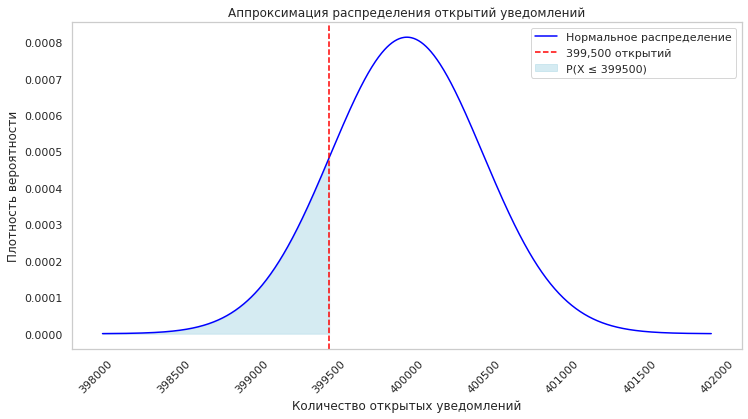

Вероятность того, что уведомление откроют не более 399,5 тыс. пользователей: 15.3700%


In [44]:
# Параметры
n = 1000000
p = 0.4
mu = n * p
sigma = np.sqrt(n * p * (1 - p))

# Значения для графика
x = np.linspace(mu - 4 * sigma, mu + 4 * sigma, 1000)
y = stats.norm.pdf(x, mu, sigma)

# Построение графика
plt.figure(figsize=(12, 6))  # Увеличиваем размер фигуры
plt.plot(x, y, color='blue', label='Нормальное распределение')
plt.fill_between(x, y, where=(x <= 399500), color='lightblue', alpha=0.5, label='P(X ≤ 399500)')
plt.title('Аппроксимация распределения открытий уведомлений')
plt.xlabel('Количество открытых уведомлений')
plt.ylabel('Плотность вероятности')
plt.axvline(x=399500, color='red', linestyle='--', label='399,500 открытий')
plt.xticks(rotation=45)  # Поворачиваем метки на оси X
plt.legend()
plt.grid()
plt.show()

# Вероятность
z = (399500 - mu) / sigma
probability = round(100*stats.norm.cdf(z), 2)
print(f'Вероятность того, что уведомление откроют не более 399,5 тыс. пользователей: {probability:.4f}%')

### Вывод о проделанной работе (Шаг 7 Задача 2)

В данной задаче нами был проведен анализ вероятности открытия push-уведомлений, рассылаемых клиентам мобильного приложения. Учитывая, что уведомления открывают около 40% пользователей, была подобрана выборка, в рамках которой планируется рассылка 1 миллиона уведомлений. Наша цель заключалась в оценке вероятности того, что уведомление откроют не более 399,5 тысяч пользователей.

### Используемый метод

Для решения этой задачи мы воспользовались **аппроксимацией нормального распределения**. Поскольку количество уведомлений, которые будут открыты, может быть охарактеризовано биномиальным распределением (с фиксированным количеством испытаний и фиксированной вероятностью успеха), мы применили центральную предельную теорему, которая позволяет использовать нормальное распределение для больших выборок.

Была построена кривая нормального распределения. Мы также определили область, соответствующую количеству открытых уведомлений не более 399,5 тысячи, и вычислили вероятность открытия уведомлений для данного значения с использованием стандартизации (перевод в z-значение).

### Результат

После всех вычислений была получена вероятность открытия уведомлений не более 399,5 тысяч пользователями, равная **15.37%**. Это значение говорит о том, что с вероятностью 15.37% при рассылке 1 миллиона уведомлений их откроют не более 399,5 тысяч пользователей. Таким образом, существует высокая возможность того, что большее количество пользователей все же откроет уведомление.

### Общий вывод о проделанной работе

В ходе анализа данных о пользователях сервиса аренды самокатов GoFast было выполнено несколько ключевых шагов для оценки поведения пользователей, характеристики подписок и их влияния на бизнес-показатели. 
- **Предобработка данных**: Были объединены три исходных датафрейма, и после очистки от дубликатов и приведения данных к необходимым форматам, стало возможным провести дальнейший анализ.

- **Анализ пользователей и их поведения**: Обнаружено, что пользователи с подпиской более склонны к коротким и менее разнообразным поездкам по сравнению с пользователями без подписки, что указывает на различия в использовании сервиса.

- **Финансовый анализ**: Проведена оценка общей выручки, составившей 3,878,641 рубль, а также выявлены значимые различия в помесячной выручке и продолжительности поездок между пользователями различных типов подписок.

- **Проверка гипотез**: Осуществлена проверка нескольких гипотез, касающихся времени и расстояния поездок, выручки, а также влияния обновлений на обращения в техническую поддержку. Результаты подтвердили, что подписка 'ultra' обеспечивает более длительные поездки и более высокую выручку.

- **Оценка промокодов**: Для привлечения пользователей была проанализирована необходимость рассылки промокодов. Рассчитано, что для того, чтобы гарантировать продление подписки хотя бы 100 пользователями, необходимо разослать как минимум 1161 промокод.

- **Анализ открытия уведомлений**: Исследована вероятность открытия push-уведомлений, что показало, что лишь 15.37% пользователей откроют не более 399,5 тысяч уведомлений при рассылке 1 миллиона уведомлений, но это все же указывает на высокий потенциал открываемости уведомлений.

### Рекомендации

На основе полученных результатов мы можем сделать несколько рекомендаций:


- **Углубленные исследования:** Важно провести дополнительные исследования для понимания причин низкой популярности сервиса в крупных городах, таких как Москва и Санкт-Петербург. Опросы и интервью с пользователями могут помочь выяснить, какие факторы влияют на принятие решения об использовании сервиса.

- **Оптимизация пользовательского опыта:** На основе анализа поведения пользователей следует разработать стратегии, направленные на улучшение пользовательского опыта, включая создание более интуитивно понятных маршрутов и предложений для различных возрастных групп.

- **Адаптация маркетинговых стратегий:** Необходимо адаптировать маркетинговые стратегии к выявленным предпочтениям различных групп пользователей, а также сосредоточиться на продвижении подписок, чтобы повысить их привлекательность.
Таким образом, итоги нашего анализа не только предоставляют ценные данные о текущем состоянии сервиса, но и указывают на направления, по которым GoFast может развиваться и улучшать свою конкурентоспособность на рынке аренды самокатов. Стратегическое принятие решений на основе этих выводов поможет улучшить как прибыльность бизнеса, так и общее восприятие компании пользователями.